# Week 12: An Improvement on Boundary Corner
Improving the algorithm implemented last week[[1]](#ref-1)

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [491]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices, retrieve_triangles_with_edge
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_boundary_vertices_related_edges_2D, retrieve_boundary_edges_related_vertices_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D

# Visualization
import pyvista as pv
from pyvista import examples

from scipy.spatial import Delaunay

<a name='1'></a>
## 1 - Test Example

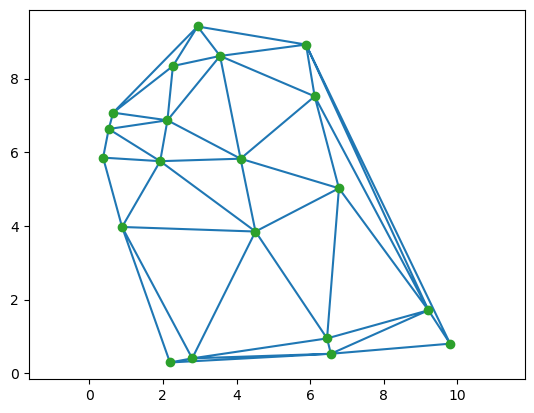

In [492]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=10
points[:, 1]*=10

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

In [493]:
monitor_id=1

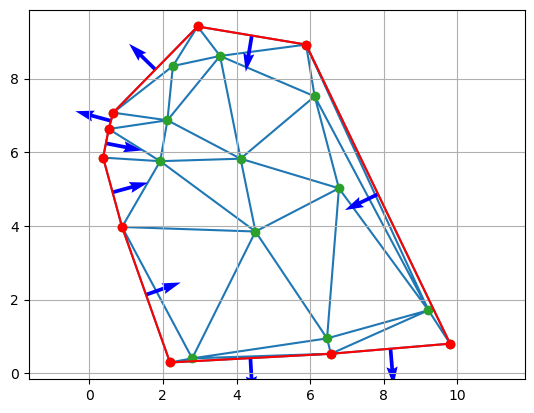

In [494]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


In [495]:
faces=tri.simplices.copy()
vertices=points.copy()
boundary_edges = retrieve_boundary_edges(tri.simplices)

In [496]:
lambda1=1
lambda2=1
num_iter = 30

<a name='2'></a>
## 2 - The Loss Function

$$Loss = E^A + E^B$$

$E^A$ is the angle term.

$$E^A = \sum_{\theta \in b} activation(\theta)$$

$$
activation(\theta) = 
\begin{cases} 
\frac{\cos^2(\theta)}{\theta} & 0 < \theta < \frac{\pi}{2} \\
\cos^2(\theta) & \frac{\pi}{2} < \theta < \pi
\end{cases}
$$



$E^B$ is the alignment term. The algorithm only measure the alignment of boundary edges.

$$E^B = \sum_{i \in b} L_i(||n_i||-1)$$

$\lambda$ is the hyper-parameter to balance the two terms.

In [497]:
def activation(angle):
    if angle < (np.pi/2):
#            return np.power(np.cos(angle), 2) / (angle if angle > 0 else 0.1) 
        return np.power(np.cos(angle), 2) / angle
    else:
        return np.power(np.sin(2*angle), 2)

In [498]:
def energy_designed(x):
    X = x.reshape((v_num, 2))
    
#     EB = 0
#     for edge in boundary_edges:
#         A, B = X[edge[0]], X[edge[1]]
#         EB += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)
        
    
    EA = 0
    boundary_angles = retrieve_boundary_angles_2D(boundary_edges, X)
    for angle_value in boundary_angles.values():
#         EA += np.power(np.cos(angle_value), 2)
        
        EA += activation(angle_value)
        
    print(EA)    
#     return lambda2*EA + lambda1*EB
    return EA

In [499]:
x0 = np.ravel(vertices)
res_designed = minimize(energy_designed, x0, options = {'maxiter': 100}
#                , method='BFGS'
              )
vertices_designed = res_designed.x.reshape((v_num,2))

3.5718044926465478
3.5718045558935763
3.5718044773623046
3.5718044926465478
3.5718044926465478
3.5718044445401267
3.571804512794409
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044956345603
3.571804492200171
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.57180449287273
3.571804487444731
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.571804489835427
3.5718044914216236
3.5718045026198317
3.5718044827124986
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.5718044926465478
3.571804457563126
3.5718044948579606
3.5718044926465478
3.5718044926465478
3.5718044939687665
3.571804492316059
3.571804500890802
3.5718045027091745
4.224632338735467
4.224632318683928
4.224632324324547
4.224632338735467
4.224632338735467
4.224632325483668
4.224632342674677
4.224632338735467
4.224632338735467
4.224632338735467
4.224632338735467
4.224632338735467
4.224632338735

0.20334901756517546
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901750825754
0.20334901766618727
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901951843254
0.20334901798700555
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334902229854127
0.20334902084589626
0.2033490154074505
0.20334902024420295
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.20334901904386513
0.2033490216432375
0.2033490204989907
0.20334901904386513
0.20334901904386513
0.20334901586469772
0.20334901727546523
0.2033490188508437
0.20334902088545037
0.0876302784770832
0.08763027861278155
0.08763027643519182
0.0876302784770832
0.0876302784770832
0.08763027837782944
0.08763027866305836
0.0876302784770832
0.0876302784770832
0.0876302784770832
0.0876302784770832
0.0876302784770832
0.0876302784770832
0.0876302802043373
0.0876302756944885
0.0876302784770

2.5174584790354207e-10
2.5174584790354207e-10
2.5171459767135606e-10
2.517955394493747e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5184937192457735e-10
2.518113543489836e-10
2.517094763704189e-10
2.5172547317935973e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5179963872517405e-10
2.5177739260691e-10
2.5174584790354207e-10
2.5174584790354207e-10
2.5186989132255107e-10
2.518230464442018e-10
2.517468495523597e-10
2.515884277903815e-10
1.3430550461480454e-11
1.3612424200881554e-11
1.3407833750918824e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3368284751904572e-11
1.352889851928397e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3433827055471283e-11
1.3428525214058297e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3430550461480454e-11
1.3429025542055895e-1

In [500]:
res_designed

      fun: 1.9839859988756124e-12
 hess_inv: array([[ 2.10110393,  0.13496573,  0.        , ...,  0.24542361,
        -1.8295679 , -0.87783748],
       [ 0.13496573,  0.75468813,  0.        , ..., -0.03983359,
        -0.12233537, -0.67163171],
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.24542361, -0.03983359,  0.        , ...,  1.0717575 ,
        -0.24182321, -0.18664013],
       [-1.8295679 , -0.12233537,  0.        , ..., -0.24182321,
         2.80741125,  0.64881101],
       [-0.87783748, -0.67163171,  0.        , ..., -0.18664013,
         0.64881101,  3.5682874 ]])
      jac: array([-3.64753375e-06, -6.85312932e-07,  0.00000000e+00,  0.00000000e+00,
        7.10348038e-07, -1.36479295e-06,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.87142110e-07, -4.98027940e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.0000

<a name='3'></a>
## 3 - Result

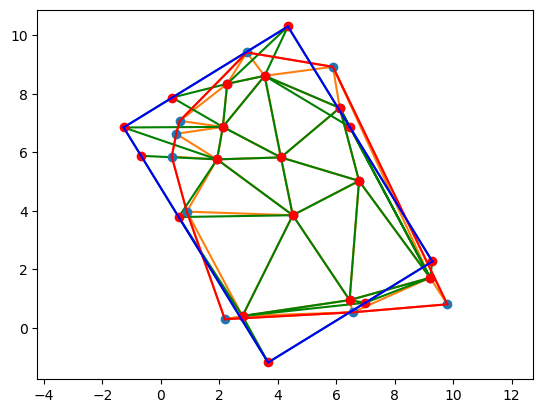

In [501]:
plt.plot(points[:,0], points[:,1], 'o')
plt.plot(vertices_designed[:,0], vertices_designed[:,1], 'o', color='red')
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.triplot(vertices_designed[:,0], vertices_designed[:,1], tri.simplices, color='green')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
    plt.plot(vertices_designed[np.array(edge), 0], vertices_designed[np.array(edge), 1], 'b-')
plt.axis('equal')
# plt.legend()
plt.show()

In [520]:
class Chen_2023_scipy:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
#         self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
#             return np.power(np.cos(angle), 2) / (angle if angle > 0 else 0.1) 
            return np.power(np.cos(angle), 2) / angle
        else:
            return np.power(np.sin(2*angle), 2)
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E = 0
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            edge1 = edge1 / np.linalg.norm(edge1)
            edge2= edge2 / np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2)
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            E_angle = self.activation(angle)
            E_align = np.sum(np.absolute(edge1)) + np.sum(np.absolute(edge2)) - 2
            
            E += self.lambda1*E_angle + self.lambda2*E_align

        return E
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict=''):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            print("hahaha")
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [521]:
def retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges):
    adjacent = {v: set() for v in boundary_vertices}

    for edge in boundary_edges:
        v1, v2 = edge
        if v1 in adjacent:
            adjacent[v1].add(v2)
        if v2 in adjacent:
            adjacent[v2].add(v1)

    result = [list(adjacent[v]) for v in boundary_vertices]

    return result

def retrieve_adjacent_vertices_with_boundary_vertex(boundary_vertices, boundary_edges):
    adjacent = retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges)
    result = [np.append(np.where(boundary_vertices==v1), np.where(boundary_vertices==v2)) for v1, v2 in adjacent]

    return np.array(result)

In [522]:
test_ = Chen_2023_scipy(vertices, faces, max_iter = 100)

In [523]:
test_.optimize_default()

In [524]:
test_.mapping()

In [525]:
test_.res

      fun: 5.103555564324998e-06
 hess_inv: array([[ 1.90760788e-01, -7.44465015e-04,  1.11814169e-01,
        -8.96674790e-04, -6.17160802e-03,  4.10811224e-05,
         1.36721640e-02,  2.92708022e-03, -8.76582085e-03,
        -6.63505533e-03,  1.11948294e-01, -8.19103862e-03,
         1.93046397e-01,  4.85485964e-03,  1.93044344e-01,
         6.32110452e-03,  1.93089466e-01,  2.27036879e-03],
       [-7.44465015e-04,  4.50452187e-01, -2.39849990e-03,
         4.50452204e-01,  7.06111479e-03, -1.55686397e-02,
        -7.56338748e-03, -1.55801414e-02,  7.10160546e-03,
         1.53913099e-02, -2.40910229e-03,  1.54108581e-02,
        -7.69696379e-04,  5.76947576e-02, -7.69733429e-04,
         5.73100750e-02, -7.62947904e-04, -1.55622010e-02],
       [ 1.11814169e-01, -2.39849990e-03,  2.74730101e-01,
        -2.48812316e-03,  7.60248779e-03, -1.80065228e-04,
        -1.32370156e-02,  1.51199938e-03,  6.07079305e-03,
         9.18975849e-03,  2.74808965e-01,  8.27115964e-03,
         1

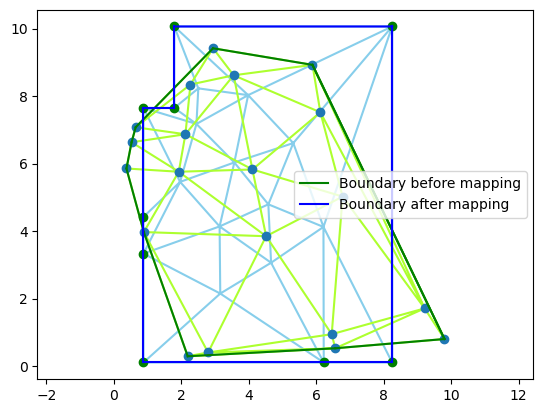

In [526]:
test_.v_plt(show_vertices=True, show_origin=True, show_BV=True, show_inner_edges=True)

<a name='4'></a>
## 4 - Intuition of Activation of Angle

I introduce the angle constrain $E^A$ to prevent boundary edges collapse. If the boundary purely bounded by the aglinment of boundary egdes collapse to a same direction, for example +X. So I add one term to measure the angles of boundary vertices. There is four situations:

+ When $\theta \to 0$, I greatly penalize it to avoid collapse of two boundary edges
+ When $\theta \to \frac{\pi}{2}$, $E^A \to 0$
+ When $\theta \to \pi$, $E^A \to 0$
+ When $\theta \in [\frac{\pi}{2}, \pi]$, use quadratic terms to penalize it

The objective function is like:

![The activation function](plot/Activation.png)

## 5 - Problems

<a name='6'></a>
## 6 - Reference

<!-- <a name='ref-1'></a>
1. [Liu C, Yu W, Chen Z, et al. Distributed poly-square mapping for large-scale semi-structured quad mesh generation[J]. Computer-Aided Design, 2017, 90: 5-17.](https://www.sciencedirect.com/science/article/pii/S0010448517300714?casa_token=JiylsQjWSkQAAAAA:RnbFGyT8qf-EsojvYlxX-if7lhZx1TwO8i0XjTwlYa-y1AqIkVAOJHRwOm5VrxhaAUkET4LSkRc)
<a name='ref-2'></a>
1. [Hormann K, Greiner G. MIPS: An efficient global parametrization method[J]. Curve and Surface Design: Saint-Malo 1999, 2000: 153-162.](https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=02e4f09c9a6d0d770d31c9289d30b7b4e9b5d974) -->